<a href="https://colab.research.google.com/github/Ariefabean15/MSIB-K2-KelasAwanPintar/blob/main/YOLOv4_tiny_Darknet_Deteksi_Masker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
#take a look at the kind of GPU we have
!nvidia-smi

Mon Oct 28 16:26:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Installing Darknet for YOLOv4 on Colab




In [ ]:
%cd /content/
%rm -rf darknet

/content


In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15867, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15867 (delta 3), reused 9 (delta 2), pack-reused 15851 (from 1)
Receiving objects: 100% (15867/15867), 14.40 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (10686/10686), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


**IMPORTANT! If you're not using a K80 GPU, then uncomment the sed command and replace the arch and code with that matching your GPU. A list can be found [here](http://arnon.dk/matching-sm-architectures-arch-and-gencode-for-various-nvidia-cards/).**

In [ ]:
#install environment from the Makefile
%cd darknet/
# compute_30, sm_30 for Tesla K80
# compute_75, sm_75 for Tesla T4
# !sed -i 's/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= -gencode arch=compute_30,code=sm_30/g' Makefile

#install environment from the Makefile
#note if you are on Colab Pro this works on a P100 GPU
#if you are on Colab free, you may need to change the Makefile for the K80 GPU
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
!make

[Errno 2] No such file or directory: 'darknet/'
/content/darknet
mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*

## Clone a helper repo
It makes training the medical mask detecting model easy.
In order to train on your own data, this repo can be used as a blueprint.
Changes to some files need to be made according to own data, but it is nothing complicated.

In [ ]:
repo_url = 'https://github.com/GotG/yolotinyv3_medmask_demo'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}


/content
Cloning into 'yolotinyv3_medmask_demo'...
remote: Enumerating objects: 1733, done.
remote: Counting objects: 100% (1732/1732), done.
remote: Compressing objects: 100% (1494/1494), done.
remote: Total 1733 (delta 119), reused 1732 (delta 119), pack-reused 1 (from 1)
Receiving objects: 100% (1733/1733), 208.88 MiB | 38.15 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Updating files: 100% (1537/1537), done.
/content/yolotinyv3_medmask_demo


In [ ]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

## Change the labels in obj.names to our current labels

In [ ]:
labels_path = '/content/yolotinyv3_medmask_demo/obj.names'
#make a list of your labels
labels = ['mask','no mask']
# labels = ['good','bad']

with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/yolotinyv3_medmask_demo/obj.names

mask
no mask

## Change the number of classes in obj.data.
The paths are relative so no change there as long as the folder/file structure/names are not changed.

In [ ]:
import re
objdata = '/content/yolotinyv3_medmask_demo/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)
s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/yolotinyv3_medmask_demo/obj.data

classes= 2
train  = /content/yolotinyv3_medmask_demo/train.txt
valid  = /content/yolotinyv3_medmask_demo/valid.txt
names = /content/yolotinyv3_medmask_demo/obj.names
backup = backup/

### Now that we see which parameters are of importance, let's modify them according to our dataset.

In [ ]:
# set the number of max_batches - min 2000 per class:
max_batch=4000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3


#cfg_file = '/content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg'
cfg_file = '/content/yolotinyv3_medmask_demo/yolov4-tiny.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)


## Start the model training

In [ ]:
%cd ../darknet/
!./darknet detector train /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg /content/yolotinyv3_medmask_demo/yolov4-tiny.conv.29 -dont_show -ext_output -map

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.523422), count: 52, class_loss = 0.496516, iou_loss = 0.209323, total_loss = 0.705839 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.652522), count: 183, class_loss = 1.441299, iou_loss = 9.159169, total_loss = 10.600468 
 total_bbox = 163245, rewritten_bbox = 0.042268 % 


 Tensor Cores are disabled until the first 3000 iterations are reached.
 (next mAP calculation at 1000 iterations) 681/4000: loss=1.0 hours left=0.9
 681: 0.969358, 1.121573 avg loss, 0.000561 rate, 0.834257 seconds, 43584 images, 0.883997 hours left
Loaded: 0.000087 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.505700), count: 34, class_loss = 0.373232, iou_loss = 0.101364, total_loss = 0.474596 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.648798), count: 213, class_l

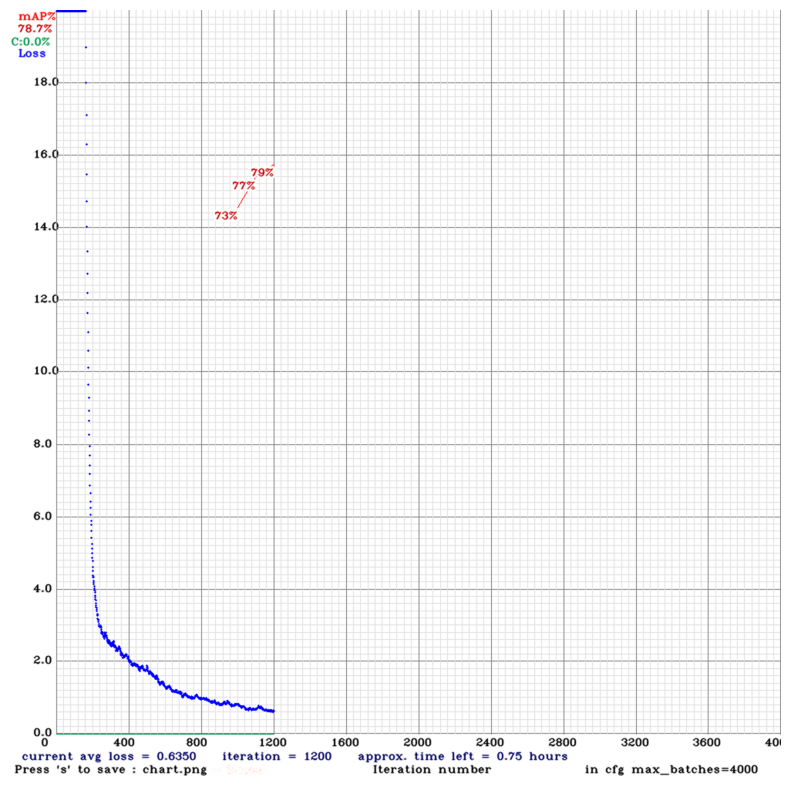

In [ ]:
imShow("chart_yolov4-tiny.png")

## Check the model performance
The metrics run on the test images so they may not be fully representative, only indicative

In [ ]:
!./darknet detector map /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg "/content/darknet/backup/yolov4-tiny_best.weights" -points 0

 CUDA-version: 12020 (12020), cuDNN: 8.9.6, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	     

## Run detection on an image. I choose one of the test images from test.txt

 CUDA-version: 12020 (12020), cuDNN: 8.9.6, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	     

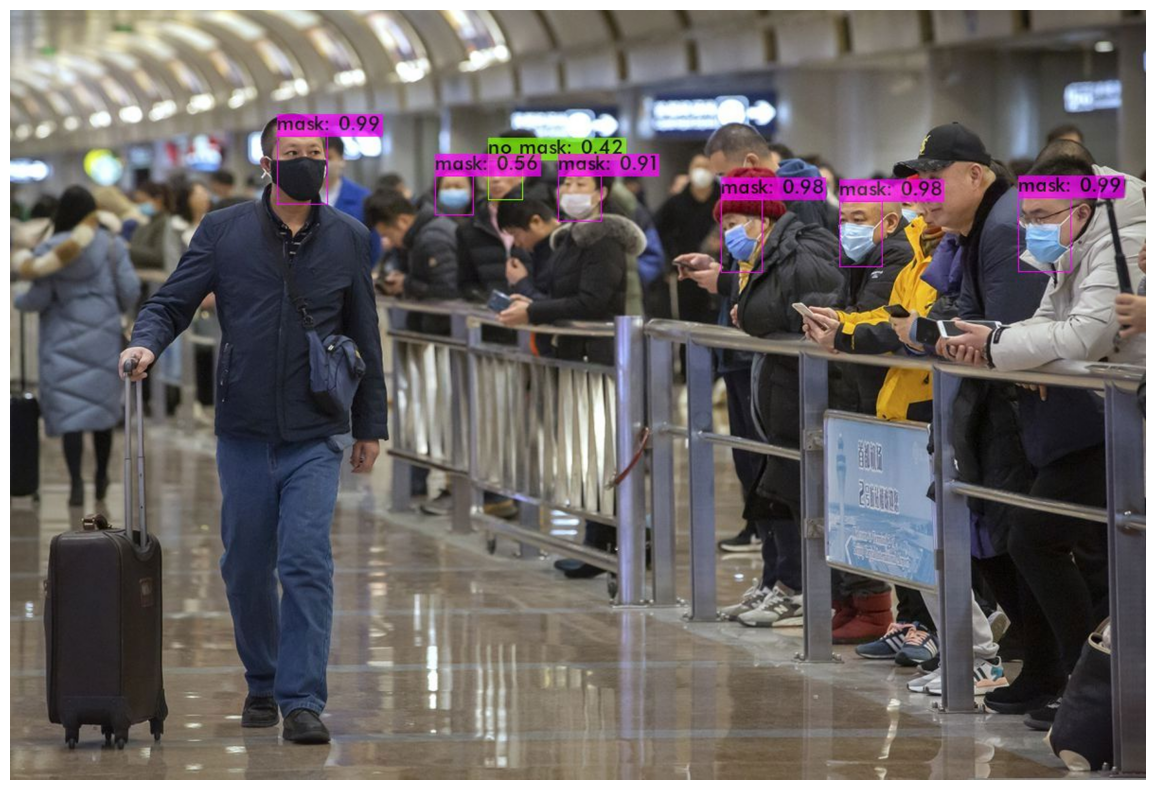

In [ ]:
!./darknet detector test /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" /content/yolotinyv3_medmask_demo/obj/0633.jpg -ext_output
imShow('predictions.jpg')

# Step 7: Running YOLOv4 on Video in the Cloud!

You can also run YOLOv4 object detections on video in your Google Colab VM. Follow the cells below to see how to run videos from your local machine or from your Google Drive!

## Local Machine Video
Here is how to upload video from local machine, run detector and then download video showing detections.

In [ ]:
!wget -O test.mp4 "https://github.com/ibaiGorordo/Social-Distance-Feedback/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4"

--2024-10-28 16:48:53--  https://github.com/ibaiGorordo/Social-Distance-Feedback/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ibaiGorordo/Social-Distance-Feedback-For-The-Blind/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4 [following]
--2024-10-28 16:48:53--  https://github.com/ibaiGorordo/Social-Distance-Feedback-For-The-Blind/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ibaiGorordo/Social-Distance-

In [ ]:
!./darknet detector demo /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" -dont_show test.mp4 -i 0 -out_filename results.avi

Streaming output truncated to the last 5000 lines.
no mask: 36% 
mask: 36% 

FPS:18.6 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

mask: 50% 

FPS:18.3 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

mask: 33% , no mask: 43% 
mask: 36% 

FPS:18.0 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

no mask: 68% 
mask: 45% 

FPS:17.6 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

no mask: 86% 
mask: 47% 

FPS:19.1 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

no mask: 40% 
mask: 37% 

FPS:19.0 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

mask: 64% 

FPS:19.5 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

no mask: 52% 
mask: 77% 
mask: 36% 

FPS:19.9 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

no mask: 71% 
no mask: 44% 
mask: 79% 

FPS:19.8 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

mask: 27% , no mask: 56% 
mask: 71% 

FPS:20.1 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

no mask: 69% 
mask: 70% 

FPS:20.3 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

mask: 82% 
mask: 52% 

FPS:20.4 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

no mask: 85% 
mask:

In [ ]:
# download the video with detections shown
from google.colab import files

video_path = 'results.avi'
files.download(video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

In [ ]:
files.download('/content/darknet/backup/yolov4-tiny_best.weights')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>